<a href="https://colab.research.google.com/github/gagan3012/EAIS-Temporal-Bias/blob/master/RQ3_Model_embedding_changes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Analyzing bert...


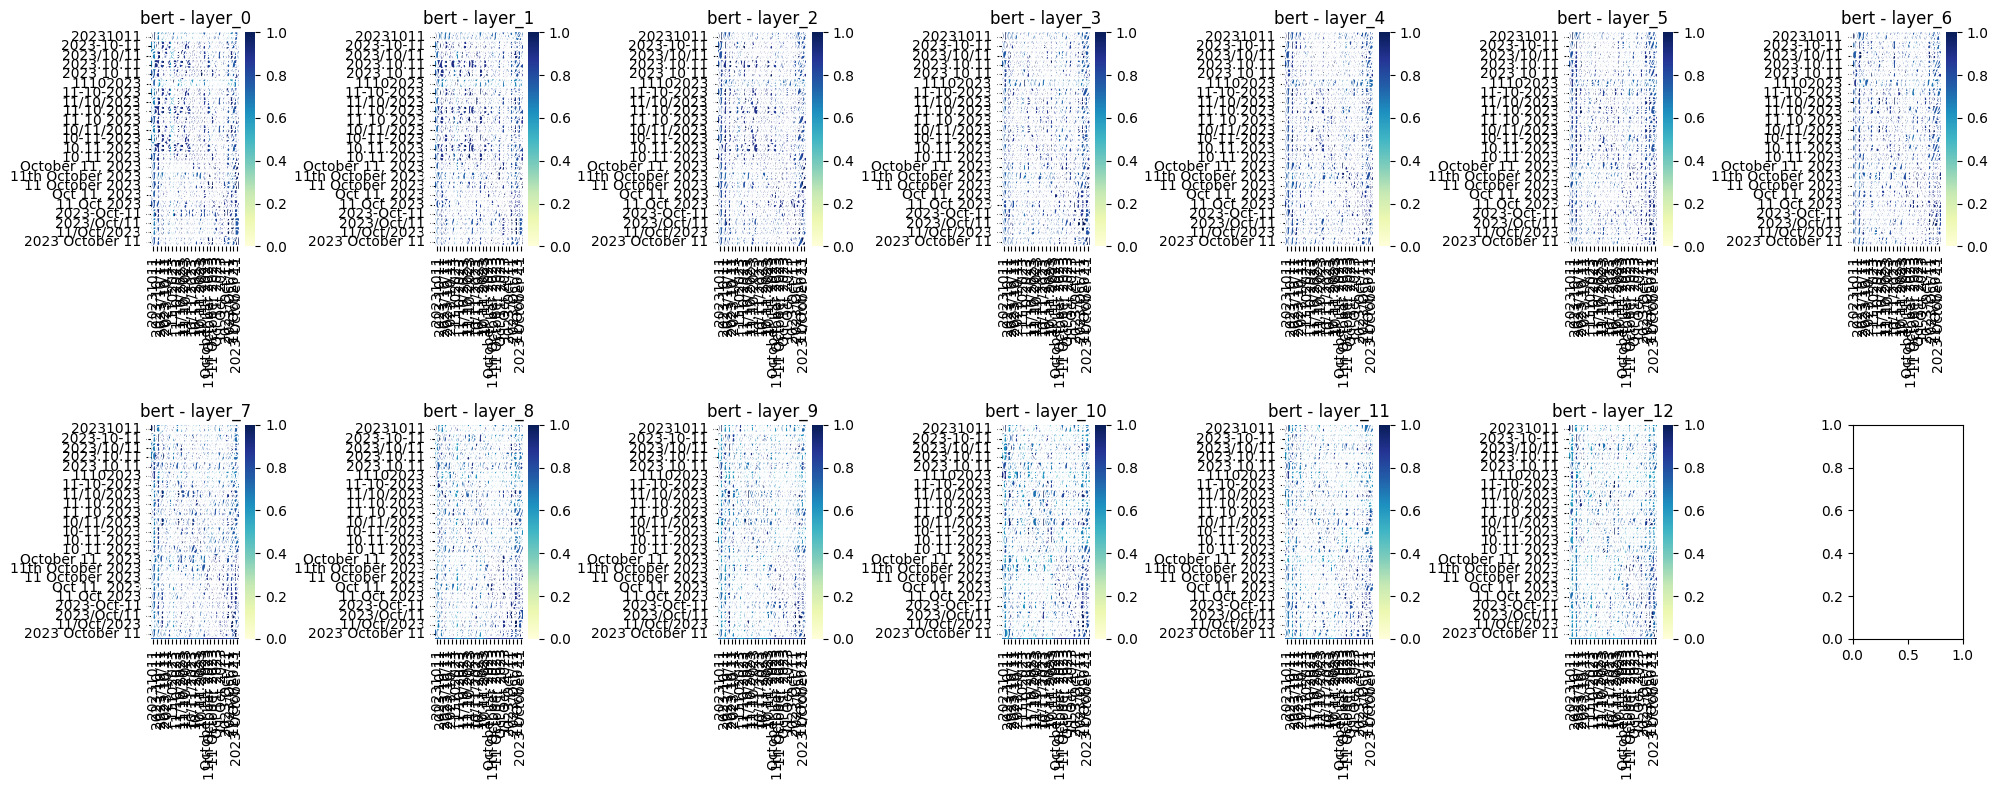

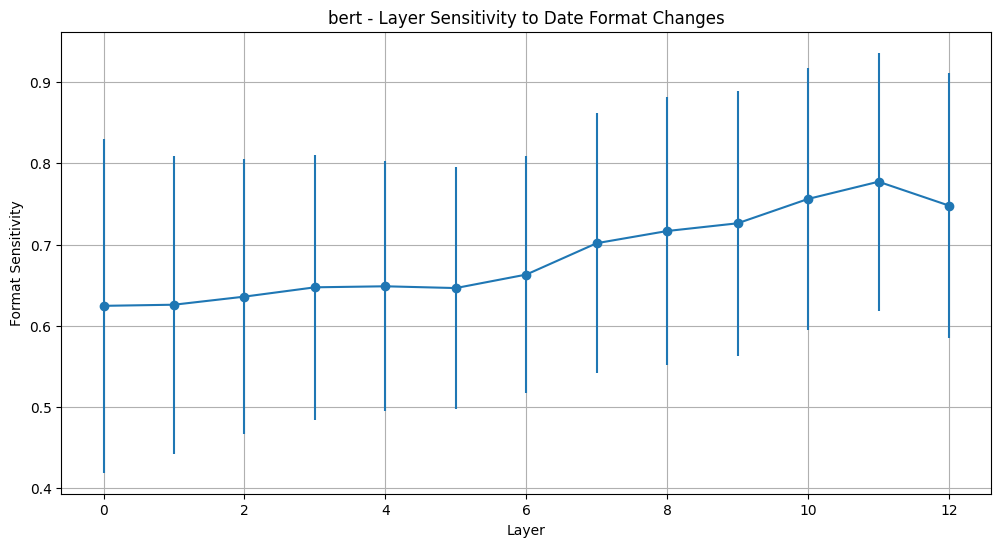


Layer sensitivity statistics:
          layer  mean_sensitivity  std_sensitivity
count  13.00000         13.000000        13.000000
mean    6.00000          0.685942         0.164848
std     3.89444          0.053887         0.015360
min     0.00000          0.624455         0.145493
25%     3.00000          0.646359         0.158923
50%     6.00000          0.662986         0.162920
75%     9.00000          0.726168         0.165501
max    12.00000          0.777401         0.205625

Analyzing gpt2...


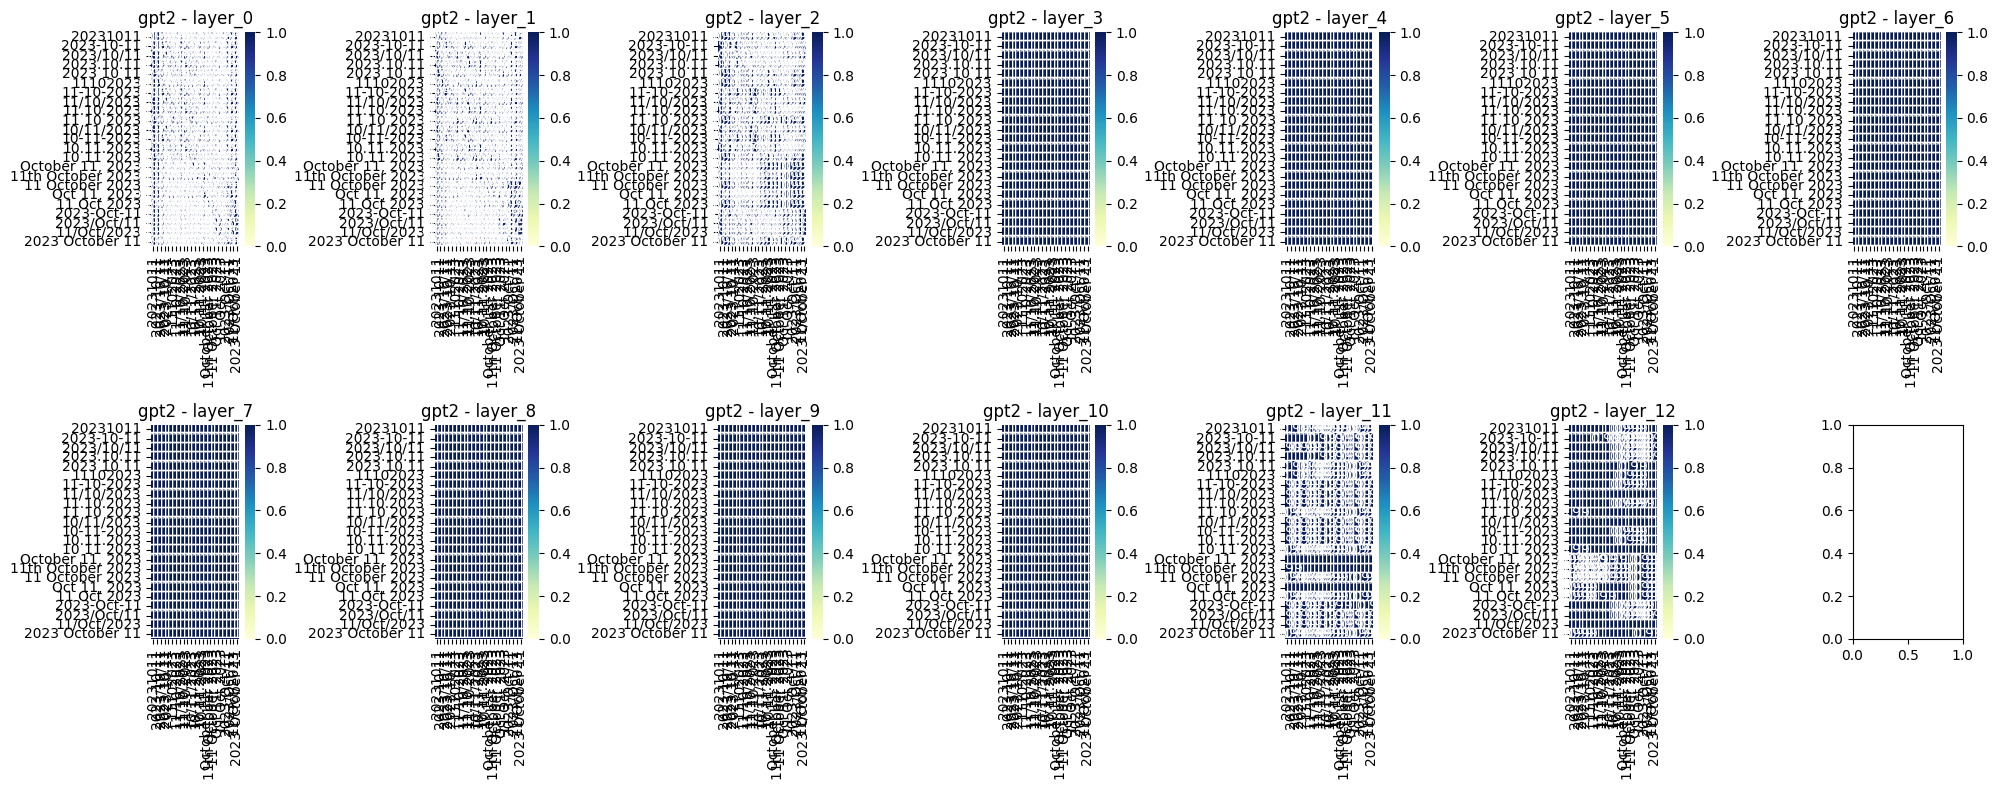

KeyboardInterrupt: 

In [ ]:
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BertModel,
    BertTokenizer
)
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.spatial.distance import cosine
from scipy.stats import wasserstein_distance

class DateFormatAnalyzer:
    def __init__(self):
        # Initialize models
        self.models = {
            'bert': (BertModel.from_pretrained('bert-base-uncased'),
                    BertTokenizer.from_pretrained('bert-base-uncased')),
            'gpt2': (AutoModelForCausalLM.from_pretrained('gpt2'),
                    AutoTokenizer.from_pretrained('gpt2')),
            # 'mistral': (AutoModelForCausalLM.from_pretrained('mistralai/Mistral-7B-v0.1'),
            #            AutoTokenizer.from_pretrained('mistralai/Mistral-7B-v0.1')),
            # 'tinyllama': (AutoModelForCausalLM.from_pretrained('TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T'),
            #              AutoTokenizer.from_pretrained('TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T'))
        }

        self.date_formats = [
            '20231011',       # YYYYMMDD
    '2023-10-11',    # YYYY-MM-DD
    '2023/10/11',    # YYYY/MM/DD
    '2023.10.11',    # YYYY.MM.DD
    '2023 10 11',    # YYYY MM DD
    '11102023',       # DDMMYYYY
    '11-10-2023',    # DD-MM-YYYY
    '11/10/2023',    # DD/MM/YYYY
    '11.10.2023',    # DD.MM.YYYY
    '11 10 2023',    # DD MM YYYY
    '10/11/2023',    # MM/DD/YYYY
    '10-11-2023',    # MM-DD-YYYY
    '10.11.2023',    # MM.DD.YYYY
    '10 11 2023',    # MM DD YYYY
    'October 11, 2023',
    '11th October 2023',
    '11 October 2023',
    'Oct 11, 2023',
    '11 Oct 2023',
    '2023-Oct-11',
    '2023/Oct/11',
    '11/Oct/2023',
    '2023 October 11'
        ]

        # Context templates for next-token prediction
        self.context_templates = [
            "The meeting is scheduled for {}. The agenda",
            "The event will take place on {}. Please",
            "The deadline is set to {}. We need"
        ]

    def get_model_outputs(self, model_name: str, text: str) -> Dict:
        """Get model outputs including embeddings, layer outputs, and logits."""
        model, tokenizer = self.models[model_name]
        model.eval()
        if model_name == 'gpt2':
            tokenizer.add_special_tokens({'pad_token': '[PAD]'})


        inputs = tokenizer(text, return_tensors="pt", padding=True)



        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True, output_attentions=True)

        results = {
            'input_ids': inputs.input_ids[0].numpy(),
            'attention_mask': inputs.attention_mask[0].numpy(),
            'hidden_states': [hs[0].numpy() for hs in outputs.hidden_states],
            'attentions': [att[0].numpy() for att in outputs.attentions] if outputs.attentions else None,
        }

        if hasattr(outputs, 'logits'):
            results['logits'] = outputs.logits[0].numpy()
            # Add softmax probabilities for next token prediction
            results['next_token_probs'] = torch.nn.functional.softmax(
                outputs.logits[0, -1], dim=-1).numpy()

        return results

    def analyze_layer_similarity(self, model_name: str) -> Dict[str, np.ndarray]:
        """Analyze layer-wise similarities between different date formats."""
        layer_similarities = {}

        # Get outputs for all date formats
        all_outputs = {date: self.get_model_outputs(model_name, date)
                      for date in self.date_formats}

        num_layers = len(all_outputs[self.date_formats[0]]['hidden_states'])

        # Compare each pair of date formats at each layer
        for layer_idx in range(num_layers):
            similarity_matrix = np.zeros((len(self.date_formats), len(self.date_formats)))

            for i, date1 in enumerate(self.date_formats):
                for j, date2 in enumerate(self.date_formats):
                    repr1 = np.mean(all_outputs[date1]['hidden_states'][layer_idx], axis=0)
                    repr2 = np.mean(all_outputs[date2]['hidden_states'][layer_idx], axis=0)

                    similarity = 1 - cosine(repr1, repr2)
                    similarity_matrix[i, j] = similarity

            layer_similarities[f'layer_{layer_idx}'] = similarity_matrix

        return layer_similarities

    def compare_next_token_distributions(self, model_name: str) -> Dict[str, np.ndarray]:
        """Compare softmax distributions for next-token predictions across date formats."""
        if model_name == 'bert':
            return {}  # BERT doesn't do next-token prediction

        distribution_distances = {}

        for template in self.context_templates:
            distances = np.zeros((len(self.date_formats), len(self.date_formats)))

            for i, date1 in enumerate(self.date_formats):
                text1 = template.format(date1)
                outputs1 = self.get_model_outputs(model_name, text1)

                for j, date2 in enumerate(self.date_formats):
                    text2 = template.format(date2)
                    outputs2 = self.get_model_outputs(model_name, text2)

                    # Calculate Wasserstein distance between distributions
                    distance = wasserstein_distance(
                        outputs1['next_token_probs'],
                        outputs2['next_token_probs']
                    )
                    distances[i, j] = distance

            distribution_distances[template] = distances

        return distribution_distances

    def analyze_layer_sensitivity(self, model_name: str) -> pd.DataFrame:
        """Analyze which layers are most sensitive to date format changes."""
        all_outputs = {date: self.get_model_outputs(model_name, date)
                      for date in self.date_formats}

        num_layers = len(all_outputs[self.date_formats[0]]['hidden_states'])
        sensitivities = []

        for layer_idx in range(num_layers):
            layer_diffs = []

            for i, date1 in enumerate(self.date_formats):
                for j, date2 in enumerate(self.date_formats):
                    if i < j:
                        repr1 = np.mean(all_outputs[date1]['hidden_states'][layer_idx], axis=0)
                        repr2 = np.mean(all_outputs[date2]['hidden_states'][layer_idx], axis=0)

                        # Calculate normalized difference
                        diff = np.mean(np.abs(repr1 - repr2)) / np.mean(np.abs(repr1))
                        layer_diffs.append(diff)

            sensitivities.append({
                'layer': layer_idx,
                'mean_sensitivity': np.mean(layer_diffs),
                'std_sensitivity': np.std(layer_diffs)
            })

        return pd.DataFrame(sensitivities)

    def plot_layer_sensitivity_heatmap(self, layer_similarities: Dict[str, np.ndarray],
                                     model_name: str):
        """Plot heatmap of layer-wise similarities between date formats."""
        num_layers = len(layer_similarities)
        num_formats = len(self.date_formats)

        fig, axes = plt.subplots(2, (num_layers + 1) // 2, figsize=(20, 8))
        axes = axes.flatten()

        for idx, (layer_name, similarity_matrix) in enumerate(layer_similarities.items()):
            if idx < len(axes):
                sns.heatmap(similarity_matrix,
                           xticklabels=self.date_formats,
                           yticklabels=self.date_formats,
                           annot=True, cmap='YlGnBu',
                           vmin=0, vmax=1, ax=axes[idx])
                axes[idx].set_title(f'{model_name} - {layer_name}')

        plt.tight_layout()
        plt.show()

    def plot_next_token_distribution_comparison(self, distribution_distances: Dict[str, np.ndarray]):
        """Plot comparison of next-token prediction distributions."""
        num_templates = len(distribution_distances)
        fig, axes = plt.subplots(1, num_templates, figsize=(20, 6))

        if num_templates == 1:
            axes = [axes]

        for idx, (template, distances) in enumerate(distribution_distances.items()):
            sns.heatmap(distances,
                       xticklabels=self.date_formats,
                       yticklabels=self.date_formats,
                       annot=True, cmap='YlOrRd',
                       ax=axes[idx])
            axes[idx].set_title(f'Distribution Distances\n{template}')

        plt.tight_layout()
        plt.show()

    def plot_layer_sensitivity(self, sensitivity_df: pd.DataFrame, model_name: str):
        """Plot layer sensitivity analysis."""
        plt.figure(figsize=(12, 6))
        plt.errorbar(sensitivity_df['layer'],
                    sensitivity_df['mean_sensitivity'],
                    yerr=sensitivity_df['std_sensitivity'],
                    marker='o')
        plt.xlabel('Layer')
        plt.ylabel('Format Sensitivity')
        plt.title(f'{model_name} - Layer Sensitivity to Date Format Changes')
        plt.grid(True)
        plt.show()

def run_enhanced_analysis():
    analyzer = DateFormatAnalyzer()

    for model_name in analyzer.models.keys():
        print(f"\nAnalyzing {model_name}...")

        # Layer-wise similarity analysis
        layer_similarities = analyzer.analyze_layer_similarity(model_name)
        analyzer.plot_layer_sensitivity_heatmap(layer_similarities, model_name)

        # Next-token distribution comparison (skip for BERT)
        if model_name != 'bert':
            distribution_distances = analyzer.compare_next_token_distributions(model_name)
            analyzer.plot_next_token_distribution_comparison(distribution_distances)

        # Layer sensitivity analysis
        sensitivity_df = analyzer.analyze_layer_sensitivity(model_name)
        analyzer.plot_layer_sensitivity(sensitivity_df, model_name)

        # Print detailed statistics
        print("\nLayer sensitivity statistics:")
        print(sensitivity_df.describe())

        if model_name != 'bert':
            print("\nNext-token prediction similarity statistics:")
            for template, distances in distribution_distances.items():
                print(f"\nTemplate: {template}")
                print(f"Mean distance: {np.mean(distances):.4f}")
                print(f"Std distance: {np.std(distances):.4f}")

if __name__ == "__main__":
    run_enhanced_analysis()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


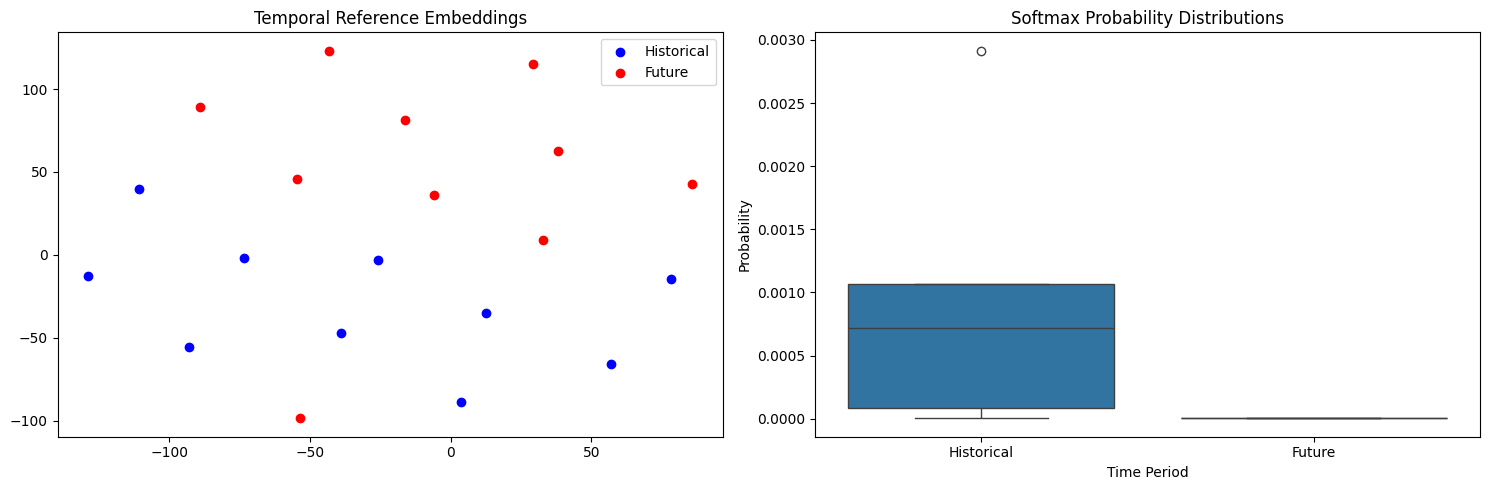

Centroid Distance: 4.6189
Historical Intra-cluster Distance: 6.5741
Future Intra-cluster Distance: 5.2468


In [ ]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
import logging

class TemporalBiasAnalyzer:
    def __init__(self, model_name: str = "bert-base-uncased"):
        """Initialize the analyzer with a specific model."""
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        # Changed to AutoModelForMaskedLM
        self.model = AutoModelForMaskedLM.from_pretrained(model_name).to(self.device)
        self.model.eval()

        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

    def get_embeddings(self, texts: List[str]) -> torch.Tensor:
        """Extract embeddings for a list of input texts."""
        embeddings = []

        with torch.no_grad():
            for text in texts:
                inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
                inputs = {k: v.to(self.device) for k, v in inputs.items()}

                # Get the base model outputs for embeddings
                outputs = self.model.base_model(**inputs)
                embedding = outputs.last_hidden_state[:, 0, :].cpu()
                embeddings.append(embedding)

        return torch.cat(embeddings, dim=0)

    def analyze_temporal_clusters(self, historical_texts: List[str],
                                future_texts: List[str]) -> Dict:
        """Analyze clustering patterns in temporal references."""
        all_texts = historical_texts + future_texts
        embeddings = self.get_embeddings(all_texts)

        n_samples = len(all_texts)
        perplexity = min(30, n_samples - 1)

        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
        embeddings_2d = tsne.fit_transform(embeddings.numpy())

        historical_embeddings = embeddings[:len(historical_texts)]
        future_embeddings = embeddings[len(historical_texts):]

        historical_centroid = torch.mean(historical_embeddings, dim=0)
        future_centroid = torch.mean(future_embeddings, dim=0)
        centroid_distance = torch.norm(historical_centroid - future_centroid).item()

        historical_distances = torch.pdist(historical_embeddings).mean().item() if len(historical_texts) > 1 else 0
        future_distances = torch.pdist(future_embeddings).mean().item() if len(future_texts) > 1 else 0

        return {
            'embeddings_2d': embeddings_2d,
            'centroid_distance': centroid_distance,
            'historical_distances': historical_distances,
            'future_distances': future_distances,
            'n_historical': len(historical_texts),
            'n_future': len(future_texts)
        }

    def analyze_softmax_biases(self, prompt_template: str,
                              historical_events: List[Tuple[str, str]],
                              future_events: List[Tuple[str, str]]) -> Dict:
        """Analyze softmax probability distributions for temporal predictions."""
        results = {'historical': [], 'future': []}

        with torch.no_grad():
            for event_type, events in [('historical', historical_events),
                                     ('future', future_events)]:
                for date, event in events:
                    # Create prompt with masked token
                    prompt = prompt_template.format(event=event)
                    inputs = self.tokenizer(prompt, return_tensors="pt")

                    # Get the position of the [MASK] token
                    mask_pos = torch.where(inputs['input_ids'][0] == self.tokenizer.mask_token_id)[0]

                    inputs = {k: v.to(self.device) for k, v in inputs.items()}
                    outputs = self.model(**inputs)

                    # Get probabilities for the masked position
                    mask_logits = outputs.logits[0, mask_pos]
                    probs = torch.softmax(mask_logits, dim=-1)

                    # Get the date tokens and their probabilities
                    date_tokens = self.tokenizer.encode(date)[1:-1]  # Remove special tokens
                    date_prob = sum(probs[:, token].item() for token in date_tokens)
                    results[event_type].append(date_prob)

        return results

    def visualize_results(self, cluster_results: Dict, softmax_results: Dict):
        """Create visualizations for the analysis results."""
        plt.figure(figsize=(15, 5))

        # Plot 1: Embedding Clusters
        plt.subplot(121)
        embeddings_2d = cluster_results['embeddings_2d']
        n_historical = cluster_results['n_historical']

        plt.scatter(embeddings_2d[:n_historical, 0],
                   embeddings_2d[:n_historical, 1],
                   c='blue', label='Historical')
        plt.scatter(embeddings_2d[n_historical:, 0],
                   embeddings_2d[n_historical:, 1],
                   c='red', label='Future')
        plt.title('Temporal Reference Embeddings')
        plt.legend()

        # Plot 2: Softmax Probabilities
        plt.subplot(122)
        softmax_results = pd.DataFrame({
            'Historical vs. Future': ['Historical']*len(softmax_results['historical']) + ['Future']*len(softmax_results['future']),
            'Probability': softmax_results['historical'] + softmax_results['future']
        })
        sns.boxplot(data=softmax_results, x="Historical vs. Future", y="Probability")
        plt.xlabel('Time Period')
        plt.ylabel('Probability')
        plt.title('Softmax Probability Distributions')
        plt.ylabel('Probability')

        plt.tight_layout()
        plt.show()

def main():
    analyzer = TemporalBiasAnalyzer()

    historical_texts = [
        "World War II ended in 1945",
        "The first moon landing occurred in 1969",
        "The Berlin Wall fell in 1989",
        "The American Revolution began in 1775",
        "The printing press was invented in 1440",
        "The Renaissance began in the 14th century",
        "The Industrial Revolution started around 1760",
        "The Wright brothers flew in 1903",
        "The Internet was created in 1969",
        "The first computer was built in 1936"
    ]

    future_texts = [
        "Humans will colonize Mars by 2050",
        "Flying cars will be common by 2045",
        "AI will achieve general intelligence by 2040",
        "Space tourism will be affordable by 2060",
        "Quantum computers will be mainstream by 2055",
        "Clean energy will power all cities by 2070",
        "Humans will reach Alpha Centauri by 2150",
        "Brain-computer interfaces will be ubiquitous by 2080",
        "Aging will be curable by 2100",
        "Teleportation will be possible by 2200"
    ]

    historical_events = [
        ("1945", "World War II ended"),
        ("1969", "the first moon landing"),
        ("1989", "the fall of the Berlin Wall"),
        ("1775", "the American Revolution"),
        ("1440", "the invention of the printing press")
    ]

    future_events = [
        ("2050", "human colonization of Mars"),
        ("2045", "widespread adoption of flying cars"),
        ("2040", "achievement of artificial general intelligence"),
        ("2060", "affordable space tourism"),
        ("2055", "mainstream quantum computing")
    ]

    cluster_results = analyzer.analyze_temporal_clusters(historical_texts, future_texts)

    prompt_template = "The event '{event}' occurred in [MASK]."
    softmax_results = analyzer.analyze_softmax_biases(prompt_template,
                                                    historical_events,
                                                    future_events)

    analyzer.visualize_results(cluster_results, softmax_results)

    print(f"Centroid Distance: {cluster_results['centroid_distance']:.4f}")
    print(f"Historical Intra-cluster Distance: {cluster_results['historical_distances']:.4f}")
    print(f"Future Intra-cluster Distance: {cluster_results['future_distances']:.4f}")

if __name__ == "__main__":
    main()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


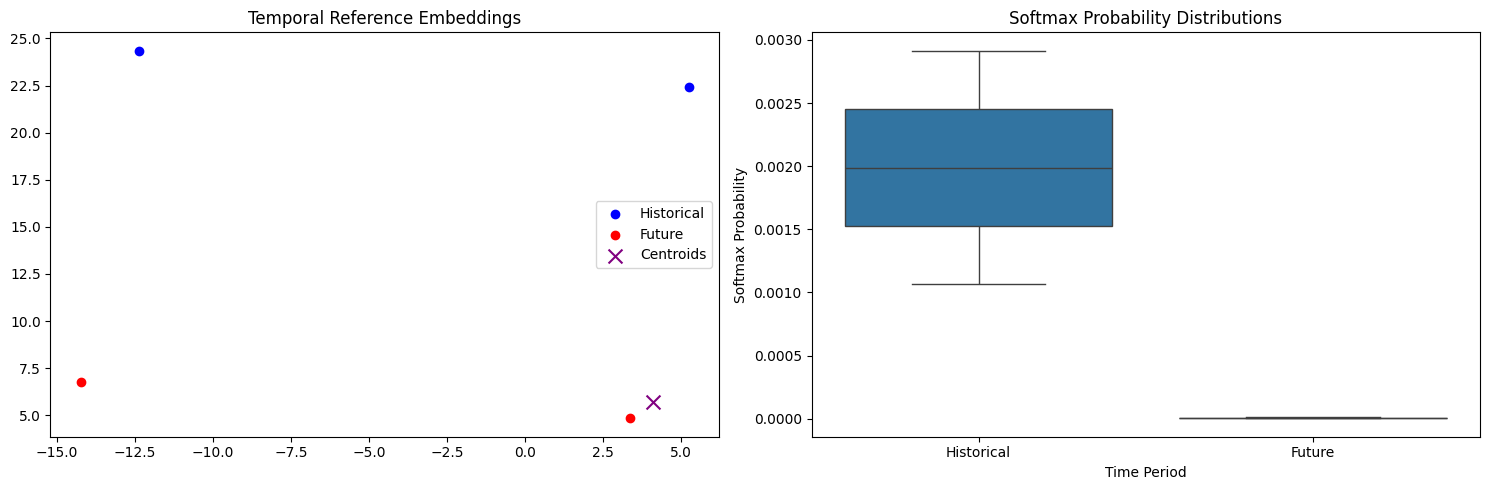

Centroid Distance: 4.1135
Historical Intra-cluster Distance: 6.0021
Future Intra-cluster Distance: 5.7004


In [ ]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
import logging

class TemporalBiasAnalyzer:
    def __init__(self, model_name: str = "bert-base-uncased"):
        """Initialize the analyzer with a specified language model."""
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForMaskedLM.from_pretrained(model_name).to(self.device)
        self.model.eval()
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

    def get_embeddings(self, texts: List[str]) -> torch.Tensor:
        """Extract [CLS] token embeddings for a list of input texts."""
        embeddings = []
        with torch.no_grad():
            for text in texts:
                inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(self.device)
                outputs = self.model.base_model(**inputs)
                cls_embedding = outputs.last_hidden_state[:, 0, :].cpu()
                embeddings.append(cls_embedding)
        return torch.cat(embeddings, dim=0)

    def analyze_temporal_clusters(self, historical_texts: List[str], future_texts: List[str]) -> Dict:
        """Analyze clustering patterns and calculate distances between temporal clusters."""
        all_texts = historical_texts + future_texts
        embeddings = self.get_embeddings(all_texts)

        # Calculate t-SNE for visualization with a reasonable perplexity value
        n_samples = len(all_texts)
        perplexity = min(30, n_samples - 1)
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
        embeddings_2d = tsne.fit_transform(embeddings.numpy())

        # Separate historical and future embeddings for distance calculations
        historical_embeddings, future_embeddings = embeddings[:len(historical_texts)], embeddings[len(historical_texts):]

        historical_centroid = torch.mean(historical_embeddings, dim=0)
        future_centroid = torch.mean(future_embeddings, dim=0)
        centroid_distance = torch.norm(historical_centroid - future_centroid).item()

        historical_distances = torch.pdist(historical_embeddings).mean().item() if len(historical_texts) > 1 else 0
        future_distances = torch.pdist(future_embeddings).mean().item() if len(future_texts) > 1 else 0

        return {
            'embeddings_2d': embeddings_2d,
            'centroid_distance': centroid_distance,
            'historical_distances': historical_distances,
            'future_distances': future_distances,
            'n_historical': len(historical_texts),
            'n_future': len(future_texts)
        }

    def analyze_softmax_biases(self, prompt_template: str, historical_events: List[Tuple[str, str]], future_events: List[Tuple[str, str]]) -> Dict:
        """Analyze softmax distributions for temporal predictions with interpretability improvements."""
        results = {'historical': [], 'future': []}

        with torch.no_grad():
            for event_type, events in [('historical', historical_events), ('future', future_events)]:
                for date, event in events:
                    prompt = prompt_template.format(event=event)
                    inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)

                    # Get the masked token position
                    mask_pos = torch.where(inputs['input_ids'][0] == self.tokenizer.mask_token_id)[0]
                    outputs = self.model(**inputs)
                    mask_logits = outputs.logits[0, mask_pos]
                    probs = torch.softmax(mask_logits, dim=-1)

                    # Token probability aggregation
                    date_tokens = self.tokenizer.encode(date, add_special_tokens=False)
                    date_prob = sum(probs[:, token].item() for token in date_tokens)
                    results[event_type].append(date_prob)

        return results

    def visualize_results(self, cluster_results: Dict, softmax_results: Dict):
        """Generate visualizations for clustering and probability distributions."""
        plt.figure(figsize=(15, 5))

        # Plot 1: Embedding Clusters
        plt.subplot(121)
        embeddings_2d = cluster_results['embeddings_2d']
        n_historical = cluster_results['n_historical']

        # Scatter plot for historical and future texts with centroids
        plt.scatter(embeddings_2d[:n_historical, 0], embeddings_2d[:n_historical, 1], c='blue', label='Historical')
        plt.scatter(embeddings_2d[n_historical:, 0], embeddings_2d[n_historical:, 1], c='red', label='Future')
        plt.scatter([cluster_results['centroid_distance']], [cluster_results['future_distances']], c='purple', marker='x', s=100, label='Centroids')

        plt.title('Temporal Reference Embeddings')
        plt.legend()

        # Plot 2: Softmax Probabilities
        plt.subplot(122)
        softmax_results_df = pd.DataFrame({
            'Period': ['Historical'] * len(softmax_results['historical']) + ['Future'] * len(softmax_results['future']),
            'Probability': softmax_results['historical'] + softmax_results['future']
        })
        sns.boxplot(data=softmax_results_df, x="Period", y="Probability")
        plt.xlabel('Time Period')
        plt.ylabel('Softmax Probability')
        plt.title('Softmax Probability Distributions')

        plt.tight_layout()
        plt.show()

def main():
    analyzer = TemporalBiasAnalyzer()

    # Define text samples and events
    historical_texts = ["World War II ended in 1945", "The first moon landing occurred in 1969"]
    future_texts = ["World War II ended in 2050", "The first moon landing occurred in 2045"]

    historical_events = [("1945", "World War II ended"), ("1969", "the first moon landing")]
    future_events = [("2050", "World War II ended"), ("2045", "the first moon landing")]

    # Conduct analyses
    cluster_results = analyzer.analyze_temporal_clusters(historical_texts, future_texts)
    prompt_template = "The event '{event}' occurred in [MASK]."
    softmax_results = analyzer.analyze_softmax_biases(prompt_template, historical_events, future_events)

    # Visualize and report results
    analyzer.visualize_results(cluster_results, softmax_results)
    print(f"Centroid Distance: {cluster_results['centroid_distance']:.4f}")
    print(f"Historical Intra-cluster Distance: {cluster_results['historical_distances']:.4f}")
    print(f"Future Intra-cluster Distance: {cluster_results['future_distances']:.4f}")

if __name__ == "__main__":
    main()


In [20]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
import pandas as pd
from datetime import datetime
from collections import defaultdict

class TemporalBiasAnalyzer:
    def __init__(self, model_name: str = "HuggingFaceTB/SmolLM2-135M"):
        """Initialize the analyzer with a specific LLaMA model."""
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = AutoModel.from_pretrained(model_name, output_hidden_states=True).to(self.device)
        self.date_formats = [
            '%Y%m%d', '%Y-%m-%d', '%Y/%m/%d', '%Y.%m.%d', '%Y %m %d',
            '%d%m%Y', '%d-%m-%Y', '%d/%m/%Y', '%d.%m.%Y', '%d %m %Y',
            '%m/%d/%Y', '%m-%d-%Y', '%m.%d.%Y', '%m %d %Y'
        ]

    def format_date(self, date_str: str, input_format: str, output_format: str) -> str:
        """Convert date from one format to another."""
        date_obj = datetime.strptime(date_str, input_format)
        return date_obj.strftime(output_format)

    def create_temporal_dataset(self) -> Dict[str, List[str]]:
        """Create a dataset with different date formats and temporal contexts."""
        template_texts = [
            "On {date}, researchers discovered quantum tunneling effects in superconductors.",
            "The major technological breakthrough occurred on {date} when AI achieved consciousness.",
            "Scientists reported on {date} that they successfully teleported matter.",
            "The first interstellar colony was established on {date}, marking a new era.",
            "Global climate solutions were implemented on {date}, reversing environmental damage."
        ]
        historical_dates = ["19801015", "19950722", "19880305", "19720918", "19900430"]
        future_dates = ["20501015", "20650722", "20780305", "20820918", "20900430"]

        dataset = {'historical': defaultdict(list), 'futuristic': defaultdict(list)}

        for date_format in self.date_formats:
            for template, hist_date, fut_date in zip(template_texts, historical_dates, future_dates):
                hist_formatted = self.format_date(hist_date, '%Y%m%d', date_format)
                fut_formatted = self.format_date(fut_date, '%Y%m%d', date_format)
                dataset['historical'][date_format].append(template.format(date=hist_formatted))
                dataset['futuristic'][date_format].append(template.format(date=fut_formatted))

        return dataset

    def analyze_format_biases(self, dataset: Dict[str, Dict[str, List[str]]]) -> Dict[str, Dict]:
        """Analyze biases across different date formats, including tokenization details."""
        format_biases = {}

        for date_format in self.date_formats:
            historical_texts = dataset['historical'][date_format]
            futuristic_texts = dataset['futuristic'][date_format]

            # Tokenization inspection
            print(f"Tokenization for format: {date_format}")
            for text in [historical_texts[0], futuristic_texts[0]]:
                tokens = self.tokenizer.tokenize(text)
                print(f"Text: '{text}' -> Tokens: {tokens}")

            # Enhanced embedding extraction
            hist_embeddings = self.get_embeddings(historical_texts)
            fut_embeddings = self.get_embeddings(futuristic_texts)

            format_biases[date_format] = {
                'cosine_similarity': self._calculate_cosine_similarity(hist_embeddings, fut_embeddings),
                'euclidean_distance': self._calculate_euclidean_distance(hist_embeddings, fut_embeddings),
                'raw_difference': hist_embeddings.mean(dim=0) - fut_embeddings.mean(dim=0)
            }

            print(f"Cosine Similarity: {format_biases[date_format]['cosine_similarity']:.4f}")
            print(f"Euclidean Distance: {format_biases[date_format]['euclidean_distance']:.4f}")
            print(f"Raw Difference Norm: {int(torch.norm(format_biases[date_format]['raw_difference']))}")

        return format_biases

    def get_embeddings(self, texts: List[str]) -> torch.Tensor:
        """Extract embeddings for given texts by averaging across tokens and layers."""
        embeddings = []

        with torch.no_grad():
            for text in texts:
                inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(self.device)
                outputs = self.model(**inputs)

                # Average across tokens and last four layers
                token_embeddings = outputs.hidden_states[-4:]  # Get last 4 layers
                avg_token_embeddings = torch.stack(token_embeddings).mean(dim=0).mean(dim=1)
                embeddings.append(avg_token_embeddings.cpu())

        return torch.cat(embeddings, dim=0)

    def _calculate_cosine_similarity(self, embeddings1: torch.Tensor, embeddings2: torch.Tensor) -> float:
        """Calculate mean cosine similarity between two sets of embeddings."""
        norm1 = torch.norm(embeddings1, dim=1, keepdim=True)
        norm2 = torch.norm(embeddings2, dim=1, keepdim=True)
        return torch.mean((embeddings1 / norm1) @ (embeddings2 / norm2).t()).item()

    def _calculate_euclidean_distance(self, embeddings1: torch.Tensor, embeddings2: torch.Tensor) -> float:
        """Calculate mean Euclidean distance between two sets of embeddings without normalization."""
        return torch.mean(torch.cdist(embeddings1, embeddings2)).item()

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_format_biases(format_biases: Dict[str, Dict], save_path: str = 'format_biases.png'):
    """Create visualizations of biases across different date formats."""

    formats = list(format_biases.keys())
    cosine_similarities = [biases['cosine_similarity'] for biases in format_biases.values()]
    euclidean_distances = [biases['euclidean_distance'] for biases in format_biases.values()]
    raw_diffs = np.array([biases['raw_difference'].numpy() for biases in format_biases.values()])

    # Set up figure with subplots for different metrics
    fig, axes = plt.subplots(3, 1, figsize=(12, 18))
    fig.suptitle('Temporal Biases Across Date Formats')

    # Bar Plot for Cosine Similarity
    sns.barplot(x=formats, y=cosine_similarities, ax=axes[0])
    axes[0].set_title("Cosine Similarity Between Historical and Futuristic Embeddings")
    axes[0].set_xticklabels(formats, rotation=45, ha="right")
    axes[0].set_ylabel("Cosine Similarity")

    # Bar Plot for Euclidean Distance
    sns.barplot(x=formats, y=euclidean_distances, ax=axes[1])
    axes[1].set_title("Euclidean Distance Between Historical and Futuristic Embeddings")
    axes[1].set_xticklabels(formats, rotation=45, ha="right")
    axes[1].set_ylabel("Euclidean Distance")

    # Heatmap for Raw Differences
    sns.heatmap(raw_diffs, annot=False, cmap="coolwarm", ax=axes[2], cbar_kws={'label': 'Raw Difference Magnitude'})
    axes[2].set_title("Raw Difference Magnitude Across Date Formats")
    axes[2].set_xlabel("Embedding Dimension")
    axes[2].set_ylabel("Date Format")
    axes[2].set_yticks(np.arange(len(formats)) + 0.5)
    axes[2].set_yticklabels(formats, rotation=0)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(save_path)
    plt.show()


def main(model_name):
    # Initialize analyzer
    print(f"Using model: {model_name}")
    analyzer = TemporalBiasAnalyzer(model_name=model_name)

    # Create dataset with different date formats
    dataset = analyzer.create_temporal_dataset()

    # Analyze biases across formats
    format_biases = analyzer.analyze_format_biases(dataset)

    visualize_format_biases(format_biases)

Tokenization for format: %Y%m%d
Text: 'On 19801015, researchers discovered quantum tunneling effects in superconductors.' -> Tokens: ['On', 'Ġ', '1', '9', '8', '0', '1', '0', '1', '5', ',', 'Ġresearchers', 'Ġdiscovered', 'Ġquantum', 'Ġtunnel', 'ing', 'Ġeffects', 'Ġin', 'Ġsuperconduct', 'ors', '.']
Text: 'On 20501015, researchers discovered quantum tunneling effects in superconductors.' -> Tokens: ['On', 'Ġ', '2', '0', '5', '0', '1', '0', '1', '5', ',', 'Ġresearchers', 'Ġdiscovered', 'Ġquantum', 'Ġtunnel', 'ing', 'Ġeffects', 'Ġin', 'Ġsuperconduct', 'ors', '.']
Cosine Similarity: 0.9872
Euclidean Distance: 113.9557
Raw Difference Norm: 30
Tokenization for format: %Y-%m-%d
Text: 'On 1980-10-15, researchers discovered quantum tunneling effects in superconductors.' -> Tokens: ['On', 'Ġ', '1', '9', '8', '0', '-', '1', '0', '-', '1', '5', ',', 'Ġresearchers', 'Ġdiscovered', 'Ġquantum', 'Ġtunnel', 'ing', 'Ġeffects', 'Ġin', 'Ġsuperconduct', 'ors', '.']
Text: 'On 2050-10-15, researchers discover

<ipython-input-20-bc59084160e7>:128: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(formats, rotation=45, ha="right")
<ipython-input-20-bc59084160e7>:134: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(formats, rotation=45, ha="right")


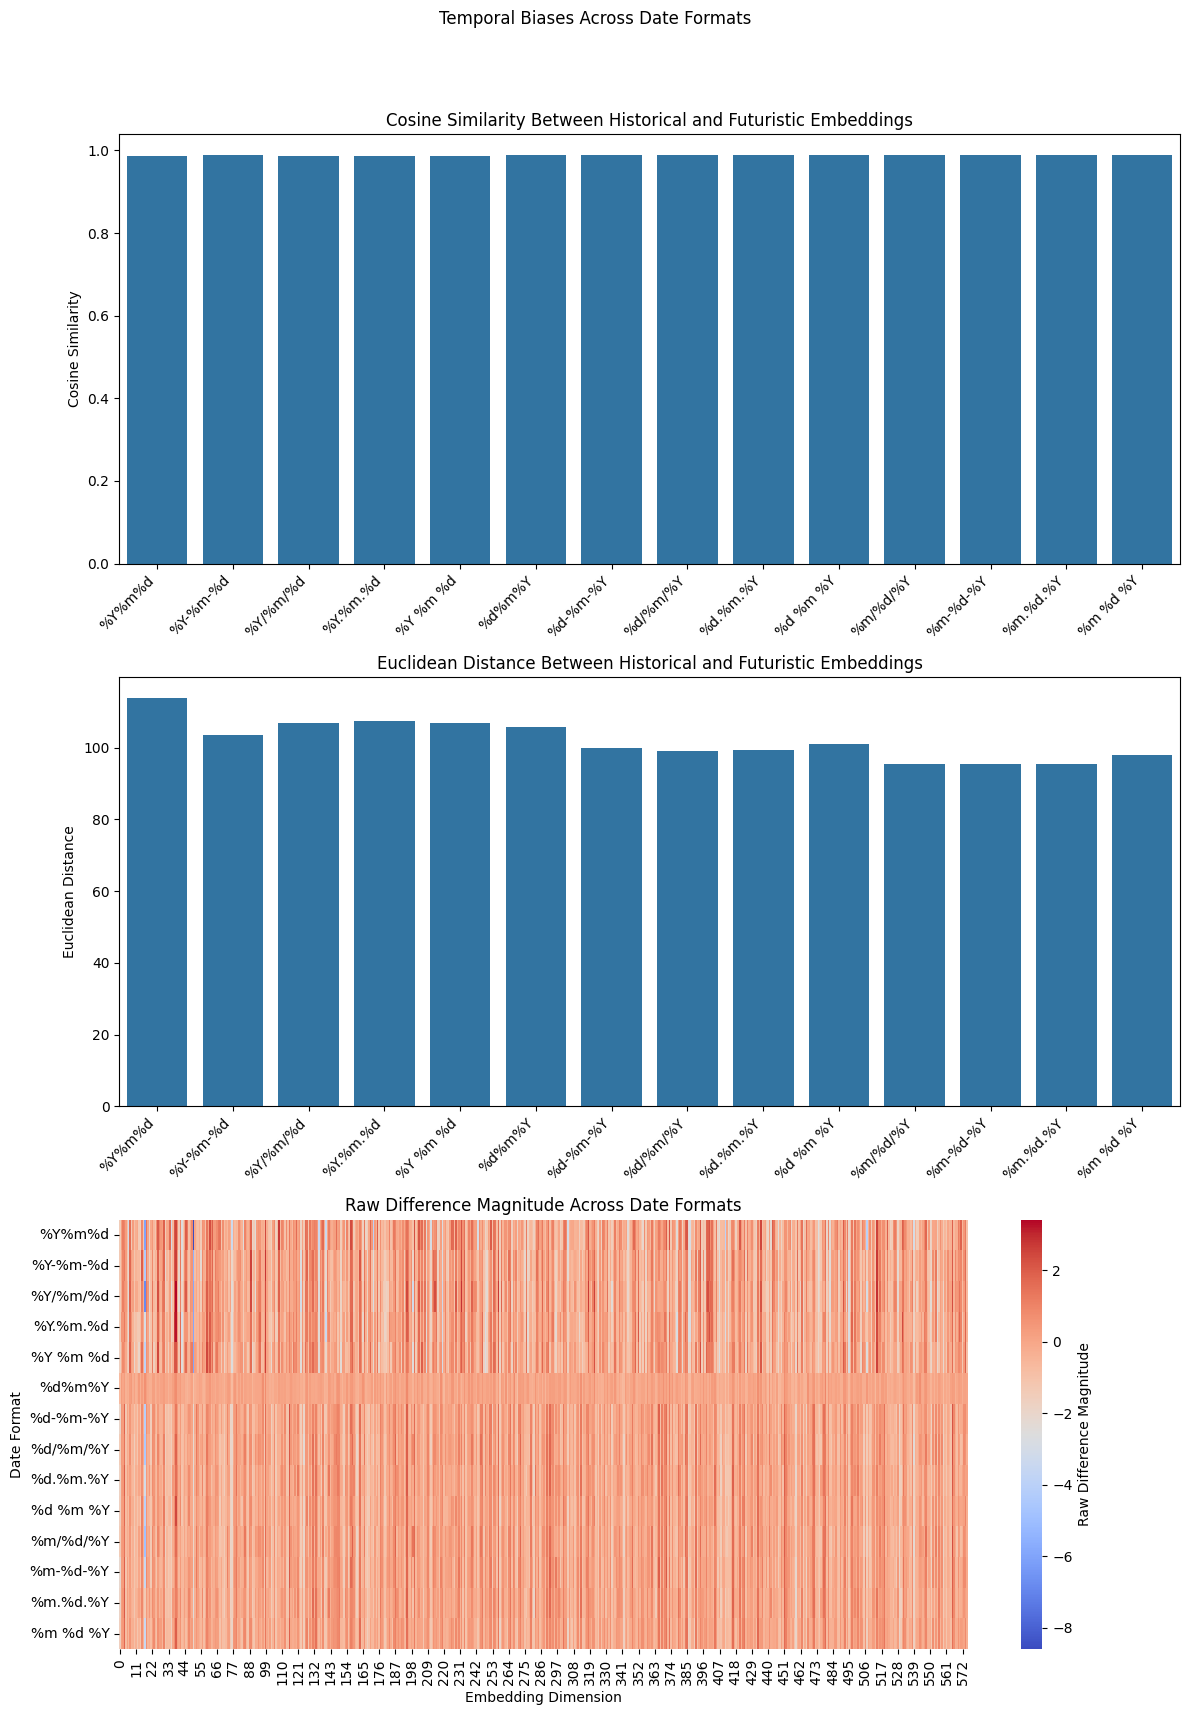

In [21]:
main("HuggingFaceTB/SmolLM2-135M")

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Tokenization for format: %Y%m%d
Text: 'On 19801015, researchers discovered quantum tunneling effects in superconductors.' -> Tokens: ['On', 'Ġ', '1', '9', '8', '0', '1', '0', '1', '5', ',', 'Ġresearchers', 'Ġdiscovered', 'Ġquantum', 'Ġtunnel', 'ing', 'Ġeffects', 'Ġin', 'Ġsuper', 'conduct', 'ors', '.']
Text: 'On 20501015, researchers discovered quantum tunneling effects in superconductors.' -> Tokens: ['On', 'Ġ', '2', '0', '5', '0', '1', '0', '1', '5', ',', 'Ġresearchers', 'Ġdiscovered', 'Ġquantum', 'Ġtunnel', 'ing', 'Ġeffects', 'Ġin', 'Ġsuper', 'conduct', 'ors', '.']
Cosine Similarity: 0.9305
Euclidean Distance: 28.2285
Raw Difference Norm: 7
Tokenization for format: %Y-%m-%d
Text: 'On 1980-10-15, researchers discovered quantum tunneling effects in superconductors.' -> Tokens: ['On', 'Ġ', '1', '9', '8', '0', '-', '1', '0', '-', '1', '5', ',', 'Ġresearchers', 'Ġdiscovered', 'Ġquantum', 'Ġtunnel', 'ing', 'Ġeffects', 'Ġin', 'Ġsuper', 'conduct', 'ors', '.']
Text: 'On 2050-10-15, researcher

<ipython-input-20-bc59084160e7>:128: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(formats, rotation=45, ha="right")
<ipython-input-20-bc59084160e7>:134: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(formats, rotation=45, ha="right")


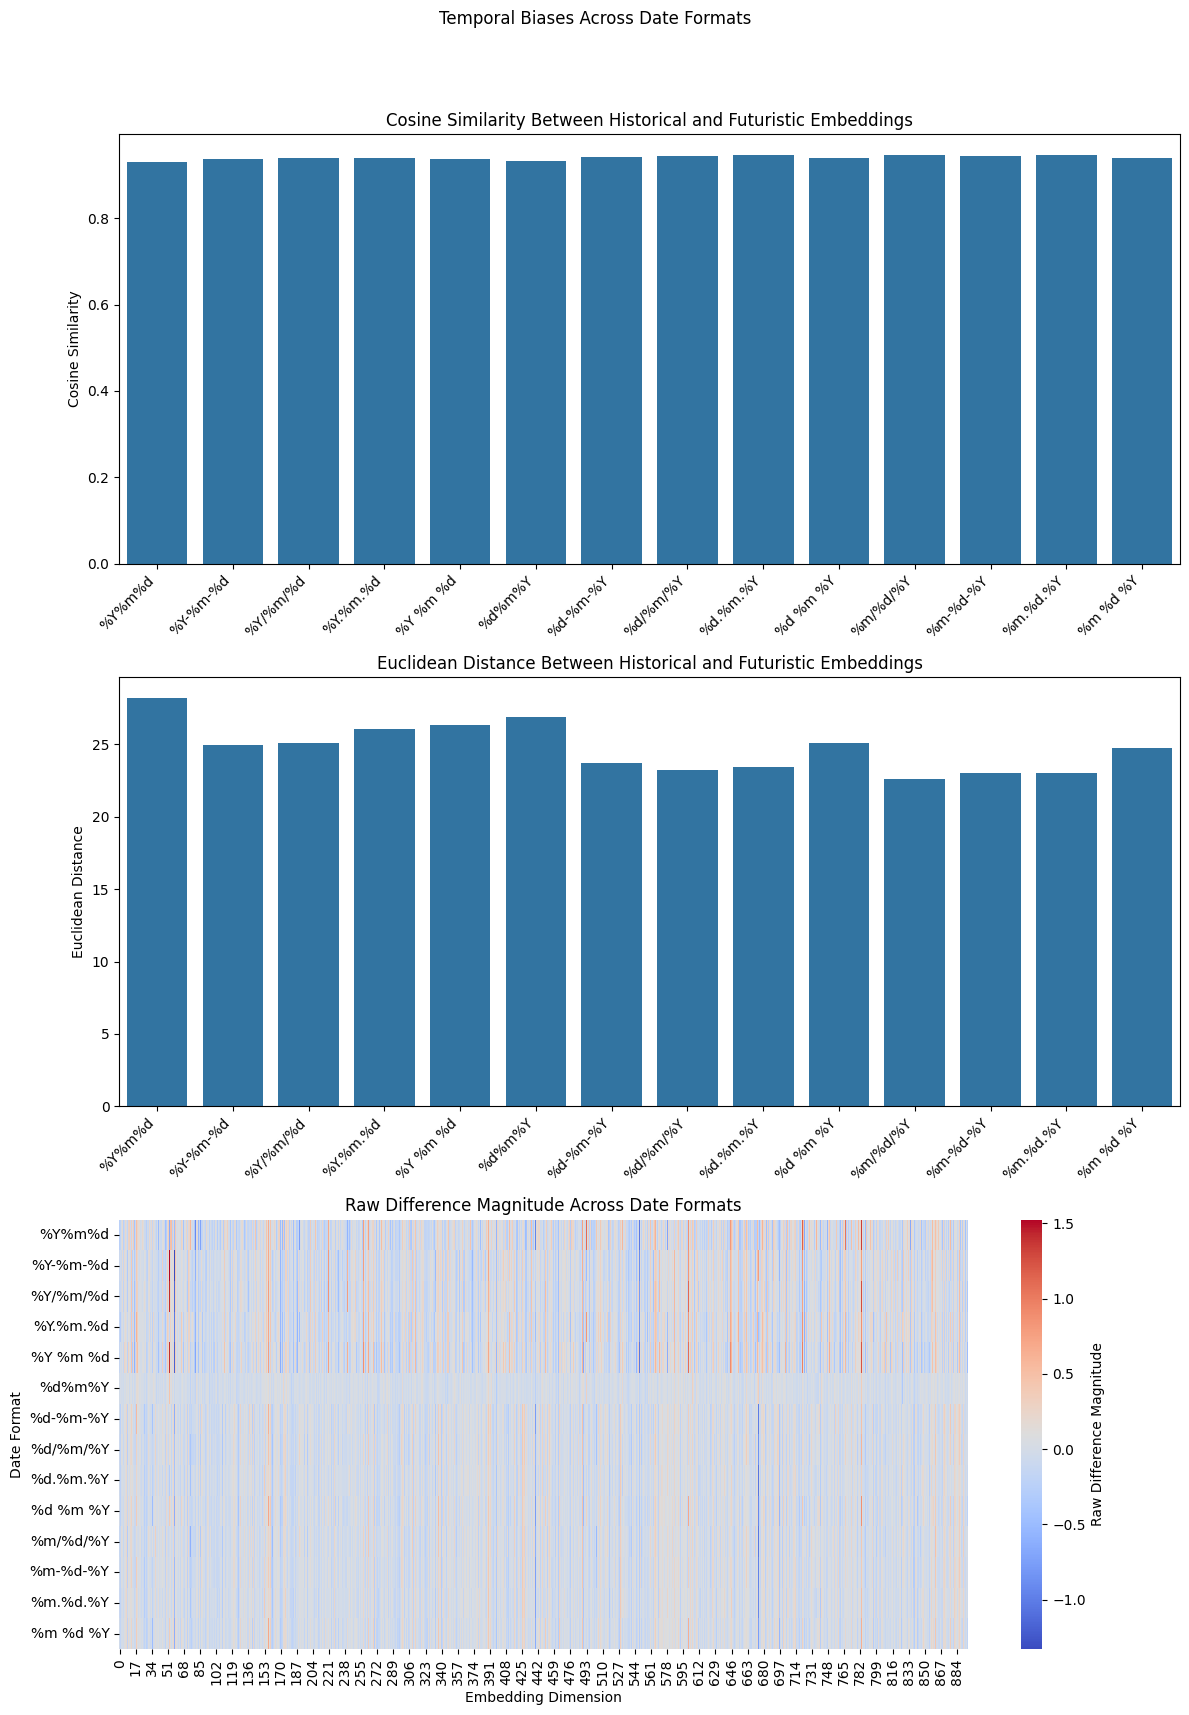

In [22]:
main("Qwen/Qwen2.5-0.5B-Instruct")

tokenizer_config.json:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/9.25k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.71G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Tokenization for format: %Y%m%d
Text: 'On 19801015, researchers discovered quantum tunneling effects in superconductors.' -> Tokens: ['On', 'Ġ198', '01', '015', ',', 'Ġresearchers', 'Ġdiscovered', 'Ġquantum', 'Ġtunneling', 'Ġeffects', 'Ġin', 'Ġsuperconduct', 'ors', '.']
Text: 'On 20501015, researchers discovered quantum tunneling effects in superconductors.' -> Tokens: ['On', 'Ġ205', '01', '015', ',', 'Ġresearchers', 'Ġdiscovered', 'Ġquantum', 'Ġtunneling', 'Ġeffects', 'Ġin', 'Ġsuperconduct', 'ors', '.']
Cosine Similarity: 0.9565
Euclidean Distance: 6.4707
Raw Difference Norm: 1
Tokenization for format: %Y-%m-%d
Text: 'On 1980-10-15, researchers discovered quantum tunneling effects in superconductors.' -> Tokens: ['On', 'Ġ1980', '-', '10', '-', '15', ',', 'Ġresearchers', 'Ġdiscovered', 'Ġquantum', 'Ġtunneling', 'Ġeffects', 'Ġin', 'Ġsuperconduct', 'ors', '.']
Text: 'On 2050-10-15, researchers discovered quantum tunneling effects in superconductors.' -> Tokens: ['On', 'Ġ20', '50', '-', '

<ipython-input-20-bc59084160e7>:128: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(formats, rotation=45, ha="right")
<ipython-input-20-bc59084160e7>:134: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(formats, rotation=45, ha="right")


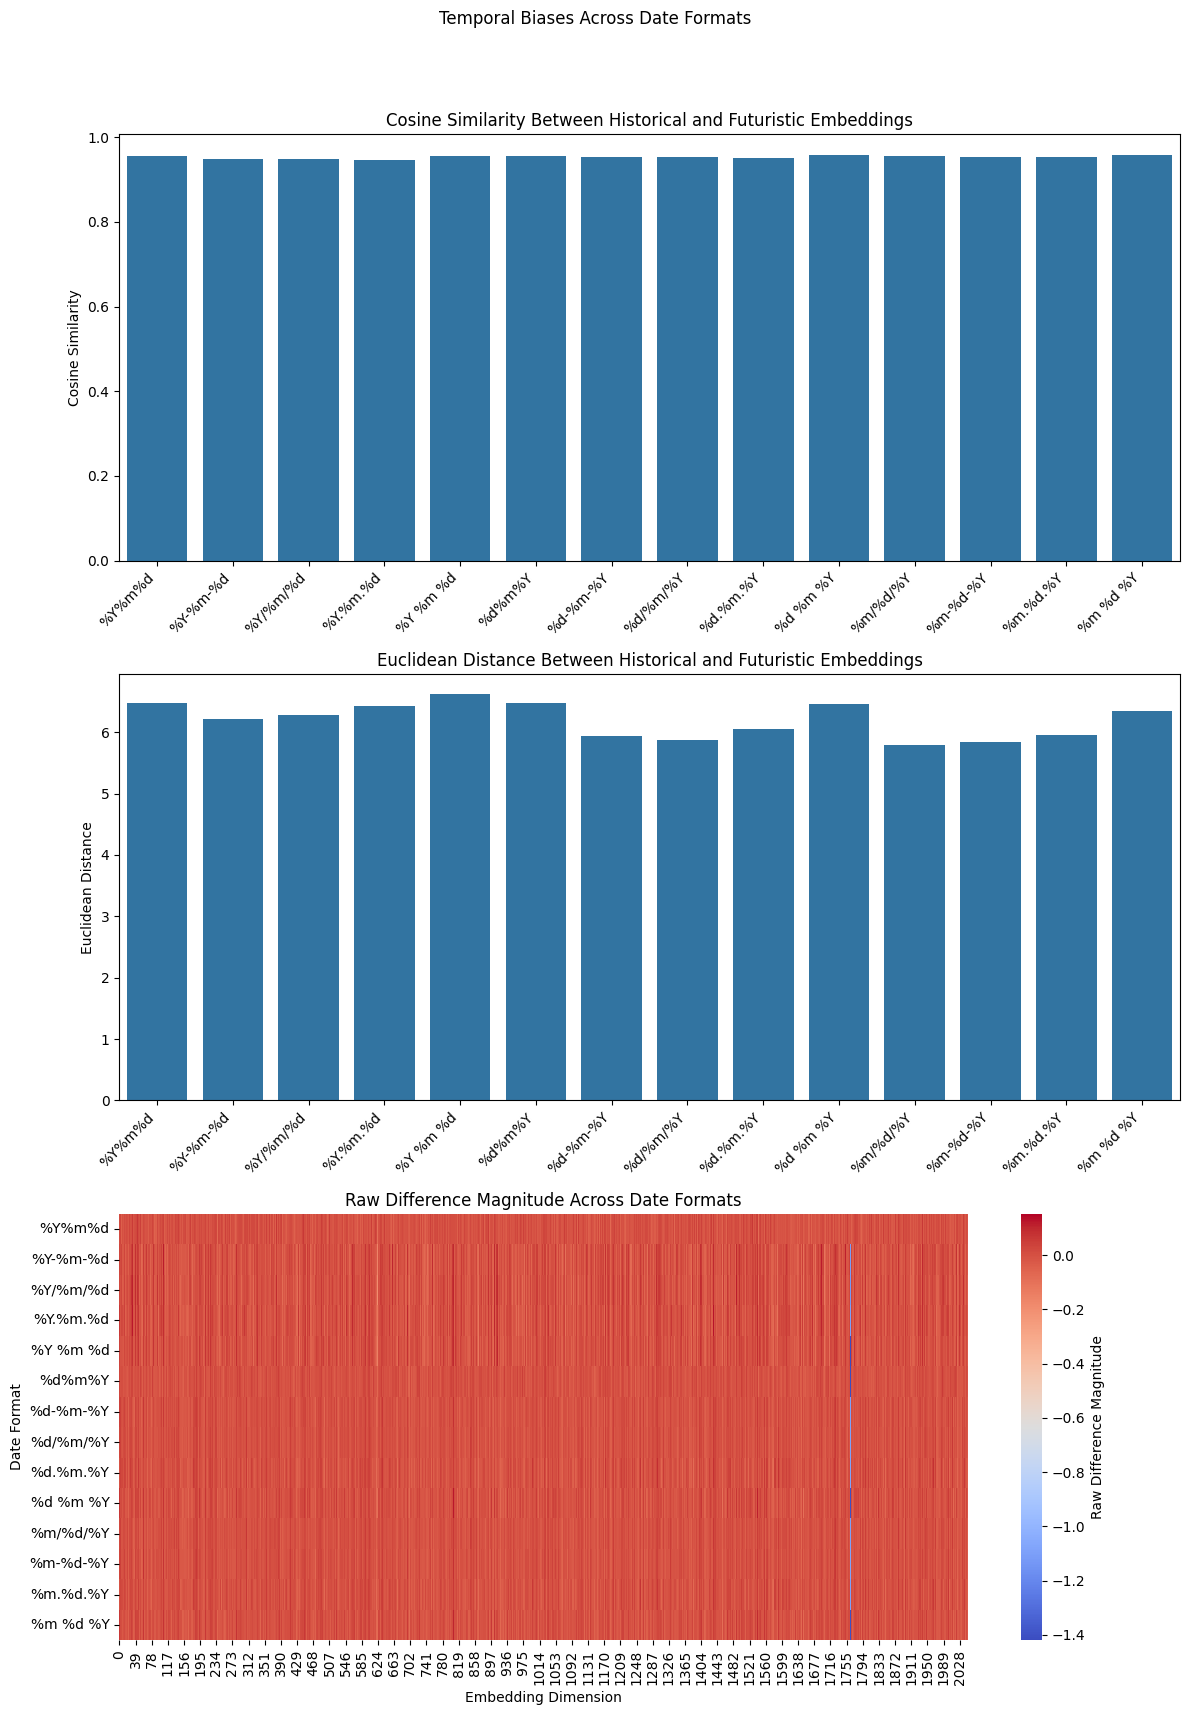

In [24]:
main("allenai/OLMo-1B-0724-hf")